In [ ]:
from google.colab import drive
drive.mount('/content/drive')
actual_root_dir ='/content/drive/MyDrive/rl_pa2/'
root_dir ='/content/pa2'
!ln -sf {actual_root_dir} {root_dir}
root_dir ='/content/pa2/'

Mounted at /content/drive


# Setup

In [ ]:
!ls {root_dir}

Acrobot-v1			BB_1_0.00050_C2048-1024C_BB
BB_10_0.00010_C1024-512C_BB	BB_1_0.00100_C2048-1024C_BB
BB_10_0.00010_C2048-1024C_BB	BB_1_0.01000_C2048-1024C_BB
BB_1_0.00001_C2048-1024C_BB	BB_2_0.00010_C1024-512C_BB
BB_1_0.00010_C1024-512-512C_BB	BB_5_0.00010_C1024-512C_BB
BB_1_0.00010_C1024-512C_BB	BB_5_0.00010_C2048-1024C_BB
BB_1_0.00010_C1024C_BB		CartPole-v1
BB_1_0.00010_C2048-1024C_BB	MountainCar-v0
BB_1_0.00010_C512-256-256C_BB	rl_pa2
BB_1_0.00010_C512-256C_BB


In [ ]:
from dataclasses import dataclass
from typing import List, Tuple
@dataclass(frozen=True)
class Params:
    h: int
    lr: float
    layer_sizes: List[int]
    seeds: Tuple[int, int]

    def dirname(self):
        return f"BB_{self.h}_{self.lr:.5f}_C{'-'.join(map(str, self.layer_sizes))}C_BB"

    def filename(self):
        return f"BB_{self.seeds[0]}_{self.seeds[1]}.npz"

In [ ]:
# import os
# import numpy as np
# from pathlib import Path
# def write_data(params, r_s, t_s):
#     dirs = Path(root_dir + params.dirname())
#     dirs.mkdir(parents=True, exist_ok=True)

#     fl = root_dir + params.dirname() + "/" + params.filename()
#     if os.path.exists(fl):
#         os.remove(fl)
#     np.savez(fl, r_s=r_s, t_s=t_s)

In [ ]:
def mavg(data, win):
    padded_x = np.pad(data, (win // 2, win // 2), mode='edge')
    return np.convolve(np.ones(win) / win, padded_x, mode='valid')

In [ ]:
from pathlib import Path
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import functools
import pandas as pd

In [ ]:
for d in Path(root_dir).iterdir():
    print(d)

/content/pa2/BB_1_0.00010_C1024-512C_BB
/content/pa2/BB_1_0.00010_C2048-1024C_BB
/content/pa2/BB_1_0.00010_C512-256C_BB
/content/pa2/BB_1_0.00010_C1024-512-512C_BB
/content/pa2/BB_1_0.00010_C512-256-256C_BB
/content/pa2/BB_1_0.00010_C1024C_BB
/content/pa2/rl_pa2
/content/pa2/BB_1_0.00100_C2048-1024C_BB
/content/pa2/BB_1_0.01000_C2048-1024C_BB
/content/pa2/BB_1_0.00001_C2048-1024C_BB
/content/pa2/BB_1_0.00050_C2048-1024C_BB
/content/pa2/BB_10_0.00010_C2048-1024C_BB
/content/pa2/BB_10_0.00010_C1024-512C_BB
/content/pa2/BB_5_0.00010_C1024-512C_BB
/content/pa2/BB_5_0.00010_C2048-1024C_BB
/content/pa2/BB_2_0.00010_C1024-512C_BB
/content/pa2/CartPole-v1
/content/pa2/Acrobot-v1
/content/pa2/MountainCar-v0


In [ ]:
@functools.lru_cache(maxsize=None)
def load_data(poi):
    dir_path = Path(root_dir) / poi.dirname()

    rss = []
    tss = []
    for run in dir_path.iterdir():
        if run.is_file():
            raw_dat = np.load(run)
            rss.append(raw_dat['r_s'])
            tss.append(raw_dat['t_s'])
    return tss, rss

# Cart Pole Output

There are three parameters for us to play around with
1. Network Shape
2. Learning Rate
3. Return Length

We assumed that the most fundamental part of the system was the neural network itself.
A shallow or low parameter count neural network will not be able to actually learn the value and action functions. A deeper and wider neural network may overfit or never converge.

We decided to first try a series of neural network shapes. The networks were trained for 400 epsiodes each and the timetaken by each episode was recorded. The learning rate and the return length were set as the same as the tutorial network. We are aiming to choose which can reach a given average reward as soon as possible. (minimum time). To account for different ideal learning rates, we will also observer the behavior of the network with episodes. If a given architecture shows a steady upward trend, it may perform better than another network if we increase the learning rate.

In [ ]:
#@title
window = 21

layer_confs = (
    [1024, 512],
    [2048, 1024],
    [512, 256],
    [1024, 512, 512],
    [512, 256, 256],
    [1024,],
)


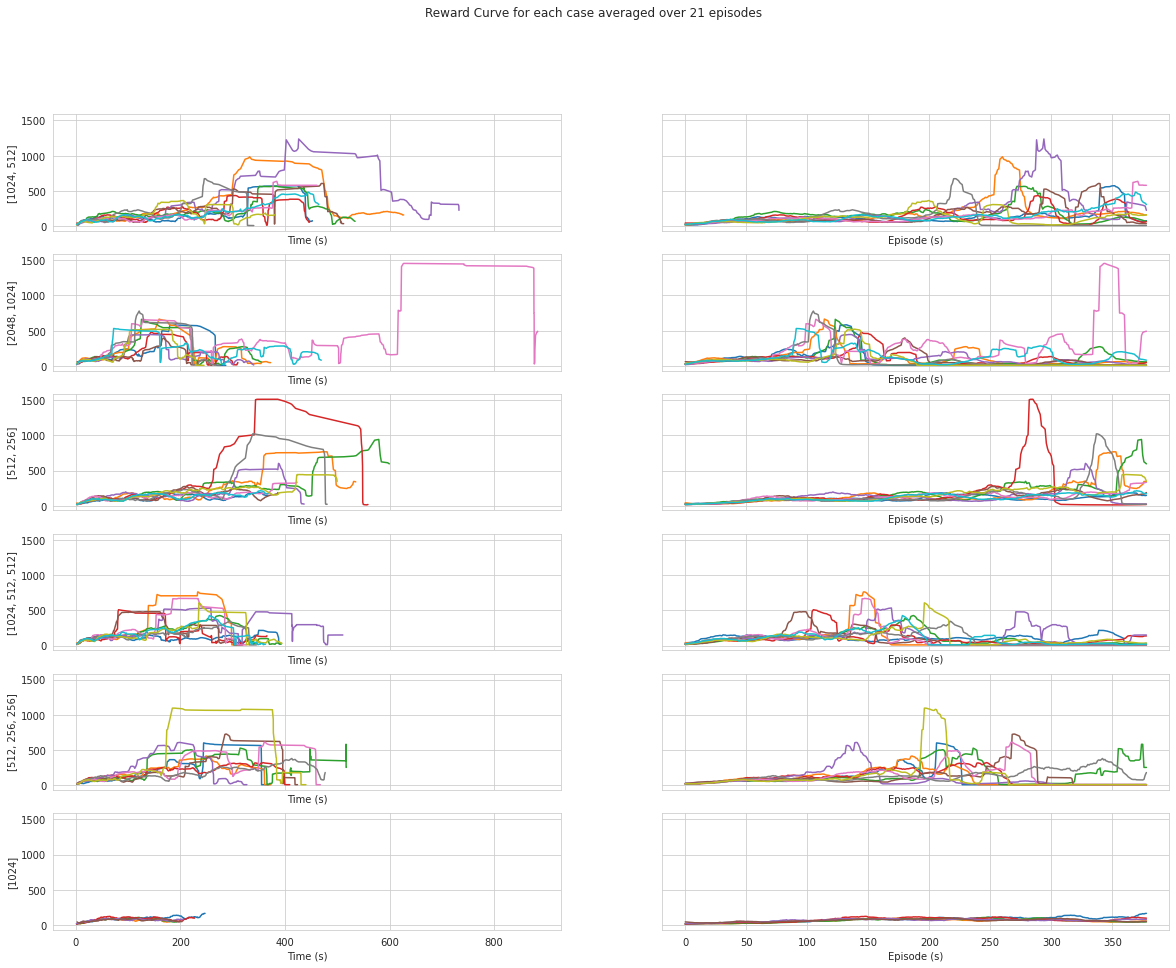

In [ ]:
#@title
def simple_plot(window, axs, tss, rss, conf):
    ax = axs[0]
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(str(conf))
    for t, r in zip(tss, rss):
        ax.plot(t[:-window], mavg(r, window)[:-window])

    ax = axs[1]
    ax.set_xlabel('Episode (s)')
    # ax.set_ylabel('Reward')
    for t, r in zip(tss, rss):
        ax.plot(mavg(r, window)[:-window])

    
f, axss = plt.subplots(len(layer_confs), 2, figsize=(20, 2.5 * len(layer_confs)), sharex='col', sharey=True)

for i, conf in enumerate(layer_confs):
    simple_plot(window, axss[i, :], 
                *load_data(Params(h=1, lr=1e-4, layer_sizes=tuple(conf), seeds = (None, None))), conf)
    
# plt.tight_layout()
plt.suptitle(f"Reward Curve for each case averaged over {window} episodes")
plt.show()

The above plot shows the raw data collected from the expierments. The row indicates the configuration. The left column is the plot of reward with time and the right column is the plot of reward with episode.

Observations:
1. The one layer neural network has much shorter training time, but cannot solve the problem. It can thus be safely discarded.
2. Most of the remaining neural networks have quite similar training time per episode. 
3. There is a very very large variance with each configuration.

In [ ]:
#@title
window = 21

layer_confs = (
    [1024, 512],
    [2048, 1024],
    [512, 256],
    [1024, 512, 512],
    [512, 256, 256],
)


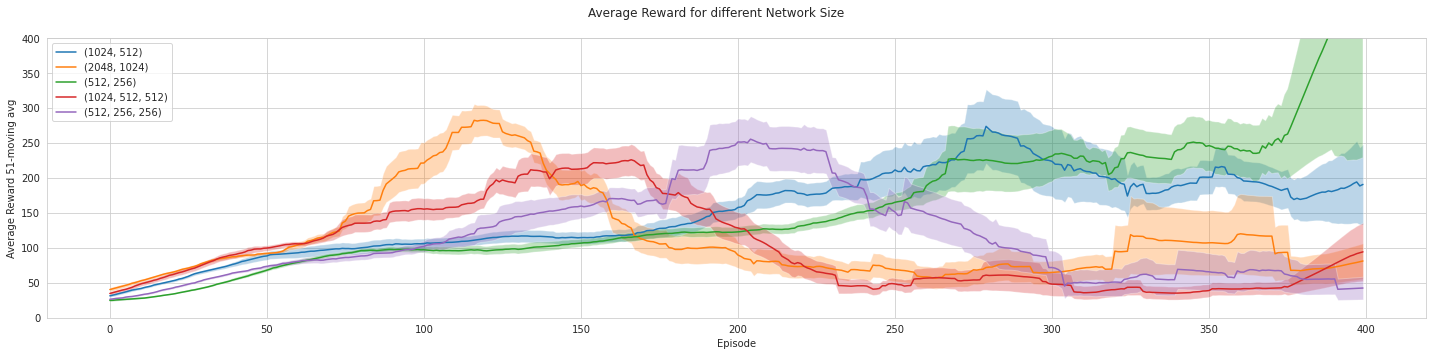

In [ ]:
#@title
window = 51

def avg_plot(window, ax, p):
    tss, rss = load_data(p)
    a = np.vstack([mavg(rs, window) for rs in rss])
    mean = a.mean(axis=0)
    ax.plot(mean, label=str(p.layer_sizes))
    err = a.std(axis=0) / 4

    plt.fill_between(range(len(mean)), mean - err, mean + err, alpha = 0.3)

f, ax = plt.subplots(1, 1, figsize=(20, 5))

for i, conf in enumerate(layer_confs):
    p = Params(h=1, lr=1e-4, layer_sizes=tuple(conf), seeds = (None, None))
    avg_plot(window, ax, p)
    
ax.set_xlabel('Episode')
ax.set_ylabel(f"Average Reward {window}-moving avg")
ax.set_ylim(0, 400)
f.suptitle("Average Reward for different Network Size")
plt.legend()
plt.tight_layout()

Next we look at the average reward curve for each configuration. 

The thickness of the curve is a factor of the standard deviation of the rewards


Observations:
1. We see that the larger networks reach a higher reward much, much faster. However their performance then drops much lower later.
2. The rewards show significantly higher variance with more episodes.

3. The widest network ((2048, 1024)) had the quickest performance. Depth had less of an impact than width.

4. The narrowest network ((512, 256) also showed slow and consistent reward increases. However as the training time for one epsiode of the narrow network is approximately the same as training time for one episode of the wider network, the wider network is preferred. If there was a significant difference, then we would make a different choice.

[203.42623270000004, 85.3700746, 244.500374, 133.5120931111111, 162.56441722222223] [227.6, 104.3, 276.875, 129.88888888888889, 182.33333333333334]


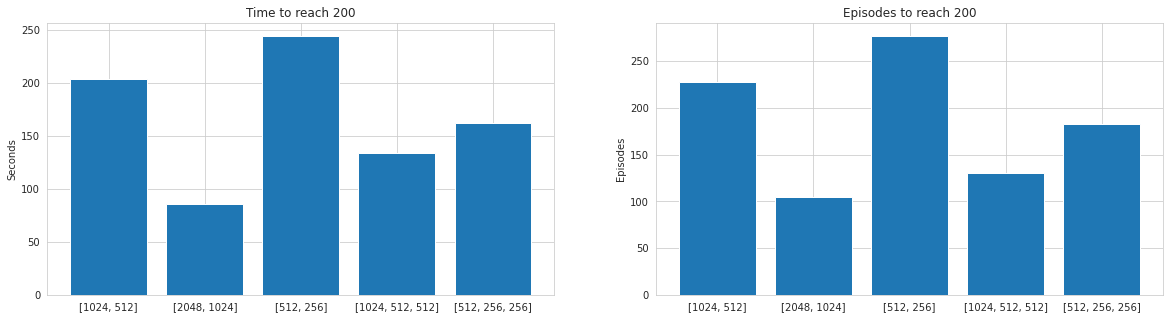

In [ ]:
#@title
window = 51

def time_to(p, window, rew=200):
    tss, rss = load_data(p)
    a = np.vstack([mavg(rs, window) for rs in rss])
    indices = np.argmax(a > rew, axis=1)

    times = [ts[i] if i != 0 else float('nan') for i, ts in zip(indices, tss)]

    n_nan = np.count_nonzero(np.isnan(times))
    if n_nan > 0.2 * len(times):
        return np.nan
    return np.nanmean(times)

def ep_to(p, window, rew=200):
    tss, rss = load_data(p)
    a = np.vstack([mavg(rs, window) for rs in rss])
    indices = np.argmax(a > rew, axis=1)

    times = [i if i != 0 else float('nan') for i in indices]

    n_nan = np.count_nonzero(np.isnan(times))
    if n_nan > 0.2 * len(times):
        return np.nan
    return np.nanmean(times)



rew_thresh=200
times = []
eps = []
for i, conf in enumerate(layer_confs):
    p = Params(h=1, lr=1e-4, layer_sizes=tuple(conf), seeds = (None, None))
    times.append(time_to(p, window, rew_thresh))
    eps.append(ep_to(p, window, rew_thresh))

print(times, eps)
f, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].title.set_text(f"Time to reach {rew_thresh} reward")
axs[0].bar(range(len(layer_confs)), times, align='center')
axs[0].set_xticks(range(len(layer_confs)), [str(c) for c in layer_confs])
axs[0].set_ylabel("Seconds")

axs[1].title.set_text(f"Episodes to reach {rew_thresh} reward")
axs[1].bar(range(len(layer_confs)), eps, align='center')
axs[1].set_xticks(range(len(layer_confs)), [str(c) for c in layer_confs])
axs[1].set_ylabel("Episodes")

plt.show()

Finally, just to confirm our more qualitative results, we have plotted the average time and episodes taken by each configuration to reach 200 reward. 


This again confirms our earlier views.

In [ ]:
#@title
window = 51

layer_confs = (
    1e-4,
    5e-4,
    1e-3,
    1e-5,
)

epp = 200

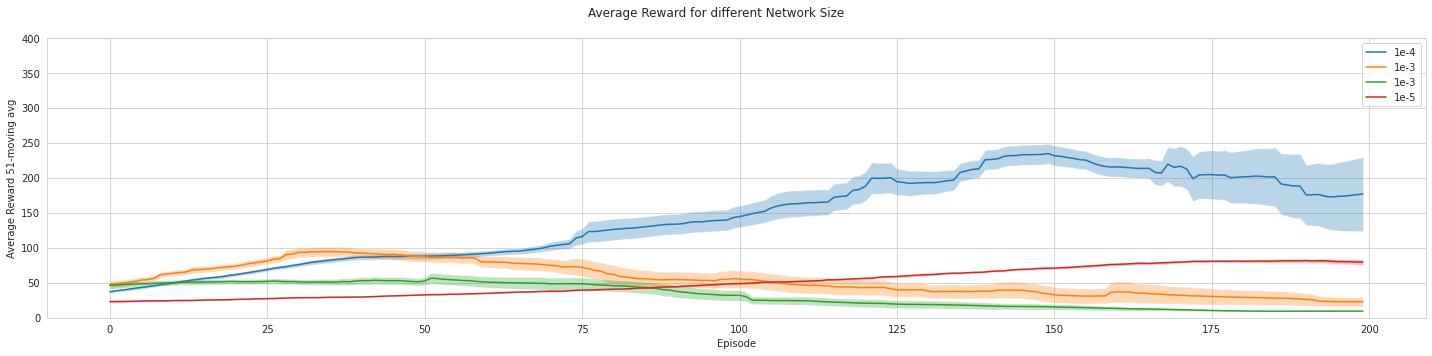

In [ ]:
#@title

def avg_plot(window, ax, p):
    tss, rss = load_data(p)
    a = np.vstack([mavg(rs[:epp], window) for rs in rss if len(rs) >= epp])
    mean = a.mean(axis=0)
    ax.plot(mean, label="1e-" + str(int(-np.log10(p.lr))))
    err = a.std(axis=0) / 4

    plt.fill_between(range(len(mean)), mean - err, mean + err, alpha = 0.3)

f, ax = plt.subplots(1, 1, figsize=(20, 5))

for i, conf in enumerate(layer_confs):
    p = Params(h=1, lr=conf, layer_sizes=(2048, 1024), seeds = (None, None))
    avg_plot(window, ax, p)
    
ax.set_xlabel('Episode')
ax.set_ylabel(f"Average Reward {window}-moving avg")
ax.set_ylim(0, 400)
f.suptitle("Average Reward for different Network Size")
plt.legend()
plt.tight_layout()

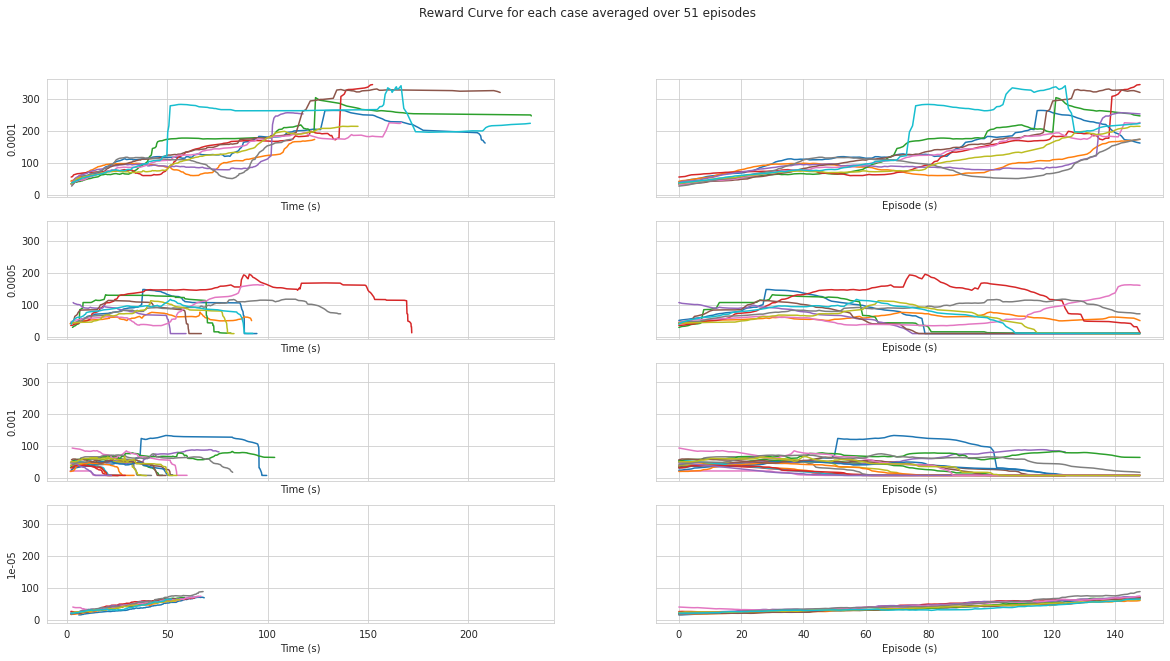

In [ ]:
#@title
def simple_plot(window, axs, tss, rss, conf):
    ax = axs[0]
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(str(conf))
    for t, r in zip(tss, rss):
        ax.plot(t[:epp-window], mavg(r, window)[:epp-window])

    ax = axs[1]
    ax.set_xlabel('Episode (s)')
    # ax.set_ylabel('Reward')
    for t, r in zip(tss, rss):
        ax.plot(mavg(r, window)[:epp-window])

    
f, axss = plt.subplots(len(layer_confs), 2, figsize=(20, 2.5 * len(layer_confs)), sharex='col', sharey=True)

for i, conf in enumerate(layer_confs):
    simple_plot(window, axss[i, :], 
                *load_data(Params(h=1, lr=conf, layer_sizes=(2048, 1024), seeds = (None, None))), conf)
    
# plt.tight_layout()
plt.suptitle(f"Reward Curve for each case averaged over {window} episodes")
plt.show()

[105.5633421, nan, nan, nan] [119.1, nan, nan, nan]


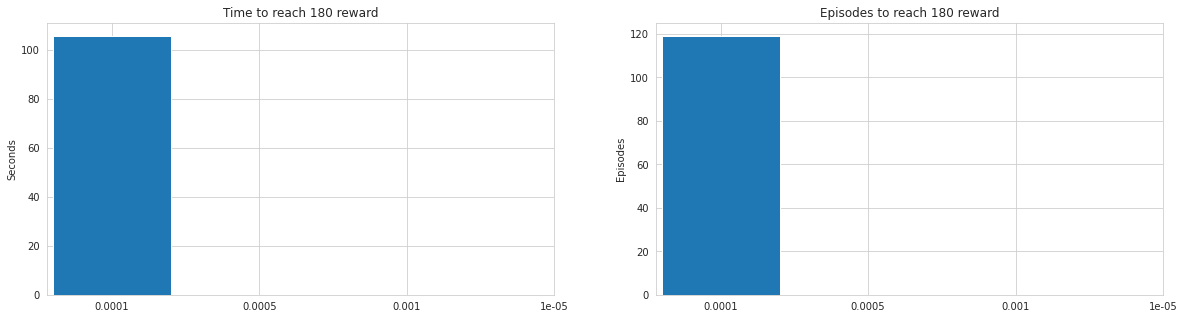

In [ ]:
#@title
window = 51

def time_to(p, window, rew=200):
    tss, rss = load_data(p)
    a = np.vstack([mavg(rs[:epp], window) for rs in rss if len(rs) >= epp])
    indices = np.argmax(a > rew, axis=1)

    times = [ts[i] if i != 0 else float('nan') for i, ts in zip(indices, tss)]

    n_nan = np.count_nonzero(np.isnan(times))
    if n_nan > 0.2 * len(times):
        return np.nan
    return np.nanmean(times)

def ep_to(p, window, rew=200):
    tss, rss = load_data(p)
    a = np.vstack([mavg(rs[:epp], window) for rs in rss if len(rs) >= epp])
    indices = np.argmax(a > rew, axis=1)

    times = [i if i != 0 else float('nan') for i in indices]

    n_nan = np.count_nonzero(np.isnan(times))
    if n_nan > 0.2 * len(times):
        return np.nan
    return np.nanmean(times)



rew_thresh=180
times = []
eps = []
for i, conf in enumerate(layer_confs):
    p = Params(h=1, lr=conf, layer_sizes=(2048, 1024), seeds = (None, None))
    times.append(time_to(p, window, rew_thresh))
    eps.append(ep_to(p, window, rew_thresh))

print(times, eps)
f, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].title.set_text(f"Time to reach {rew_thresh} reward")
axs[0].bar(range(len(layer_confs)), times, align='center')
axs[0].set_xticks(range(len(layer_confs)), [str(c) for c in layer_confs])
axs[0].set_ylabel("Seconds")

axs[1].title.set_text(f"Episodes to reach {rew_thresh} reward")
axs[1].bar(range(len(layer_confs)), eps, align='center')
axs[1].set_xticks(range(len(layer_confs)), [str(c) for c in layer_confs])
axs[1].set_ylabel("Episodes")

plt.show()

https://github.com/alex-lindt/Variance-N-Step-Actor-Critic#n-step-bootstrapping

# New

## Setup

In [ ]:
from dataclasses import dataclass
from typing import List, Tuple, Literal
import functools
import numpy as np

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

In [ ]:
def mavg(data, win):
    padded_x = np.pad(data, (win // 2, win // 2), mode='edge')
    return np.convolve(np.ones(win) / win, padded_x, mode='valid')

In [ ]:
@dataclass
class Params:
    env: Literal['Acrobot-v1', 'CartPole-v1', 'MountainCar-v0']
    h: int
    lr: float
    layer_sizes: List[int]
    seeds: Tuple[int, int]
    episodes: int

    def dirname(self):
        return f"{self.env}/BB_{self.h}_{self.lr:.5f}_C{'-'.join(map(str, self.layer_sizes))}C_BB"

    def filename(self):
        return f"BB_{self.episodes}_{self.seeds[0]}_{self.seeds[1]}.npz"

    def fullpath(self):
        return self.dirname() + '/' + self.filename

    @staticmethod
    def from_path(env, folder=None, file=None):
        if folder is None:
            h=None
            lr = None
            layers = None
        else:
            folder = folder.split('_')
            h = float(folder[1])
            lr = float(folder[2])
            layers = tuple(map(int, folder[3][1:-1].split('-')))
        if file is None:
            episodes=None
            seeds=None
        else:
            file = file.split('.')[0].split('_')
            episodes = int(file[1])
            seeds = tuple(map(int, file[2:4]))
        return Params(env=env,
                   h=h,
                   lr=lr,
                   layer_sizes=layers,
                   seeds=seeds,
                   episodes=episodes
                   )

In [ ]:
# def load_param_data(p):
#     return load_path(str(Path(root_dir)/p.dirname() / p.filename()))

@functools.lru_cache(maxsize=None)
def np_load(run):
    return np.load(run)


def load_paths(files):
    rss = []
    tss = []
    sss = []
    for run in files:
        raw_dat = np_load(run)
        rss.append(raw_dat['r_s'])
        tss.append(raw_dat['t_s'])
        tss.append(raw_dat['s_s'])
    return tss, rss, sss

In [ ]:
def clean_path(n):
    x = (n.find(' ('))
    y = (n.find(')'))
    if x != -1 and y != -1:
        n = n[:x] + n[y+1:]
    return n

## Filelist

In [ ]:
from pathlib import Path
from collections import defaultdict
from typing import Dict, List


dirs = 'Acrobot-v1', 'CartPole-v1', 'MountainCar-v0',
root = Path(root_dir)

complete_map = {}
for dir in dirs:
    dp = root / dir
    things: Dict[str, List[str]] = defaultdict(list)
    for p in dp.iterdir():
        if p.is_dir():
            name = p.name
            things[clean_path(name)].extend(((clean_path(pp.name), str(pp)) for pp in p.iterdir()))
            # things[(name)].extend(map(clean_path, (pp.name for pp in dp.iterdir())))
    print(dir)
    # print(things)
    # print(len(things.keys()))
    for conf, lst in things.items():
        if len(lst) != 0:
            print(f"{conf}:\t{len(lst)}")

    complete_map[dir] = things

Acrobot-v1
BB_inf_0.00010_C1024-512C_BB:	10
BB_1_0.00001_C2048-1024C_BB:	10
BB_1_0.00001_C1024-512C_BB:	10
BB_inf_0.00001_C2048-1024C_BB:	4
CartPole-v1
BB_1_0.00010_C1024-512C_BB:	11
BB_1_0.00001_C2048-1024C_BB:	10
BB_1_0.00001_C1024-512C_BB:	10
BB_1_0.00010_C2048-1024C_BB:	12
BB_1_0.00100_C2048-1024C_BB:	10
BB_1_0.00100_C1024-512C_BB:	10
BB_10_0.00001_C2048-1024C_BB:	10
BB_inf_0.00010_C2048-1024C_BB:	12
BB_10_0.00001_C1024-512C_BB:	10
BB_10_0.00010_C2048-1024C_BB:	10
BB_10_0.00010_C1024-512C_BB:	10
BB_10_0.00100_C2048-1024C_BB:	10
BB_10_0.00100_C1024-512C_BB:	10
BB_30_0.00001_C2048-1024C_BB:	10
BB_30_0.00001_C1024-512C_BB:	10
BB_30_0.00010_C2048-1024C_BB:	10
BB_30_0.00010_C1024-512C_BB:	10
BB_30_0.00100_C2048-1024C_BB:	10
BB_30_0.00100_C1024-512C_BB:	10
BB_inf_0.00001_C2048-1024C_BB:	10
BB_inf_0.00001_C1024-512C_BB:	10
BB_inf_0.00010_C1024-512C_BB:	10
BB_inf_0.00100_C2048-1024C_BB:	10
BB_inf_0.00100_C1024-512C_BB:	10
MountainCar-v0
BB_1_0.00001_C2048-1024C_BB:	10
BB_1_0.00001_C1024-51

## PLots

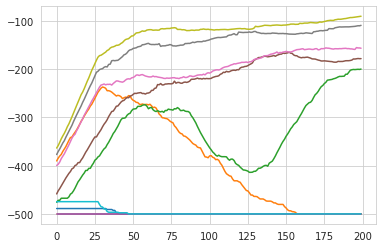

In [ ]:
tss, rss, sss = load_paths(
    map(lambda x: x[1], complete_map['Acrobot-v1']['BB_1_0.00001_C2048-1024C_BB'])
    )

for rs in rss:
    plt.plot(mavg(rs, 51))

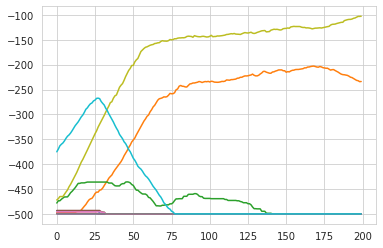

In [ ]:
tss, rss, sss = load_paths(
    map(lambda x: x[1], complete_map['Acrobot-v1']['BB_1_0.00001_C1024-512C_BB'])
    )

for rs in rss:
    plt.plot(mavg(rs, 51))

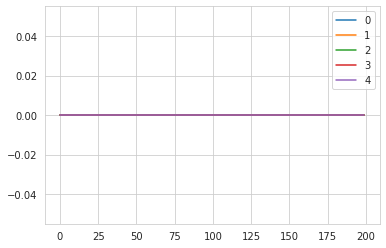

In [ ]:
tss, rss, sss = load_paths(
    map(lambda x: x[1], complete_map['MountainCar-v0']['BB_inf_0.00001_C2048-1024C_BB'])
    )

for i, rs in enumerate(rss):
    plt.plot(mavg(rs, 51), label=f"{i}")
plt.legend()

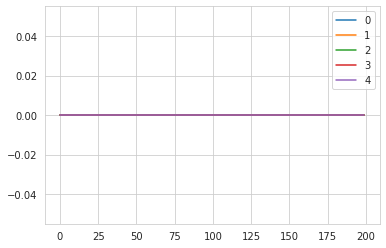

In [ ]:
tss, rss, sss = load_paths(
    map(lambda x: x[1], complete_map['MountainCar-v0']['BB_inf_0.00001_C2048-1024C_BB'])
    )

for i, rs in enumerate(rss):
    plt.plot(mavg(rs, 1), label=f"{i}")
plt.legend()

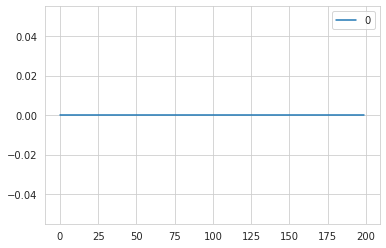

In [ ]:
tss, rss, sss = load_paths(
    map(lambda x: x[1], complete_map['MountainCar-v0']['BB_inf_0.00100_C2048-1024C_BB'])
    )

for i, rs in enumerate(rss):
    plt.plot(mavg(rs, 1), label=f"{i}")
plt.legend()

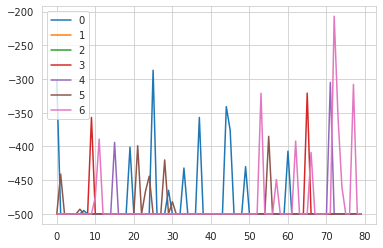

In [ ]:
tss, rss, sss = load_paths(
    map(lambda x: x[1], complete_map['Acrobot-v1']['BB_inf_0.00010_C1024-512C_BB'])
    )

for i, rs in enumerate(rss):
    plt.plot(mavg(rs, 1), label=f"{i}")
plt.legend()

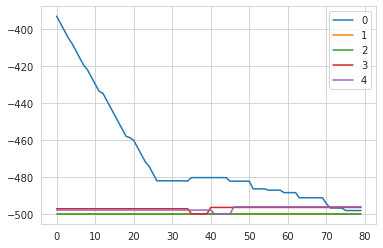

In [ ]:
tss, rss, sss = load_paths(
    map(lambda x: x[1], complete_map['Acrobot-v1']['BB_inf_0.00010_C1024-512C_BB'])
    )

for i, rs in enumerate(rss):
    plt.plot(mavg(rs, 51), label=f"{i}")
plt.legend()

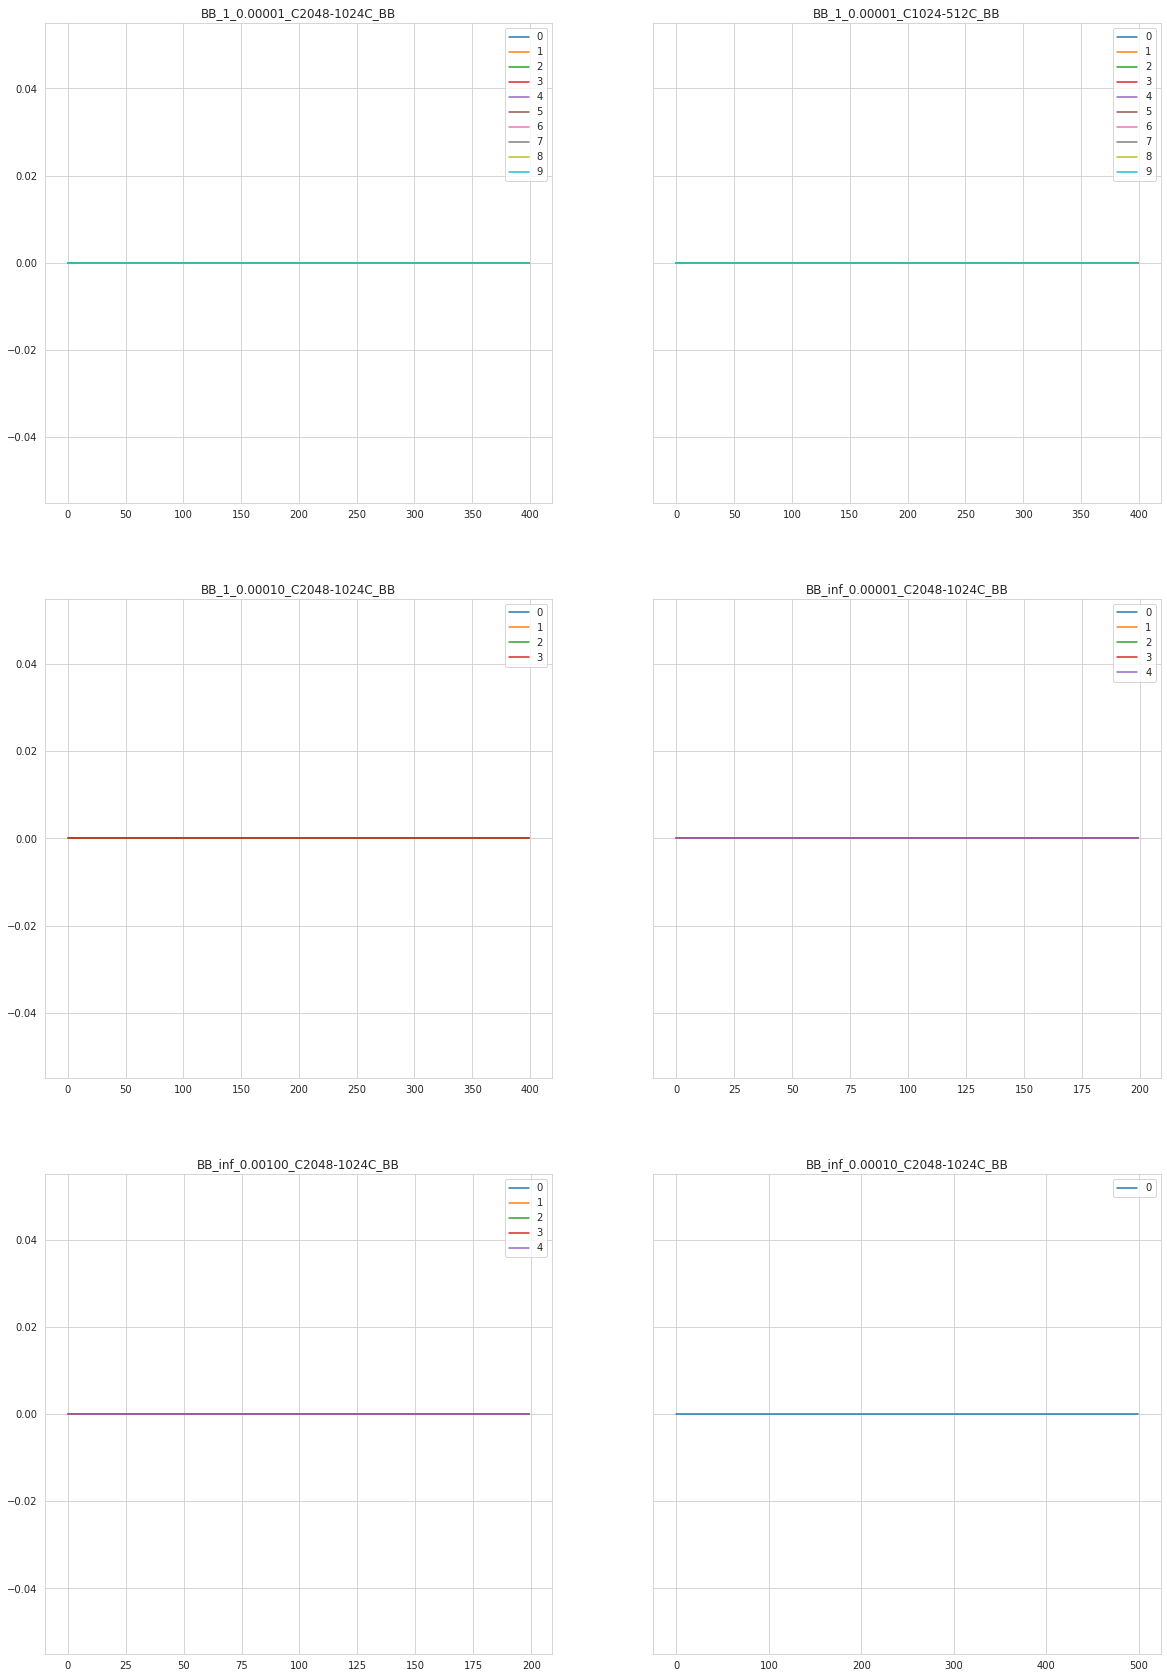

In [ ]:
env = 'MountainCar-v0'
non_zero = {k:v for k, v in complete_map[env].items() if len(v) != 0 }
n_plt = len(non_zero)

f, axs = plt.subplots(int(np.ceil(n_plt / 2)), 2, figsize=(10 * 2, n_plt * 5), sharex=False, sharey=True)
axs = axs.ravel()

for ax, (name, conf) in zip(axs, non_zero.items()):
    tss, rss, sss = load_paths(
        map(lambda x: x[1], conf)
        )
    for i, rs in enumerate(rss):
        ax.plot(mavg(rs, 51), label=f"{i}")
    ax.legend()
    ax.set_title(name)

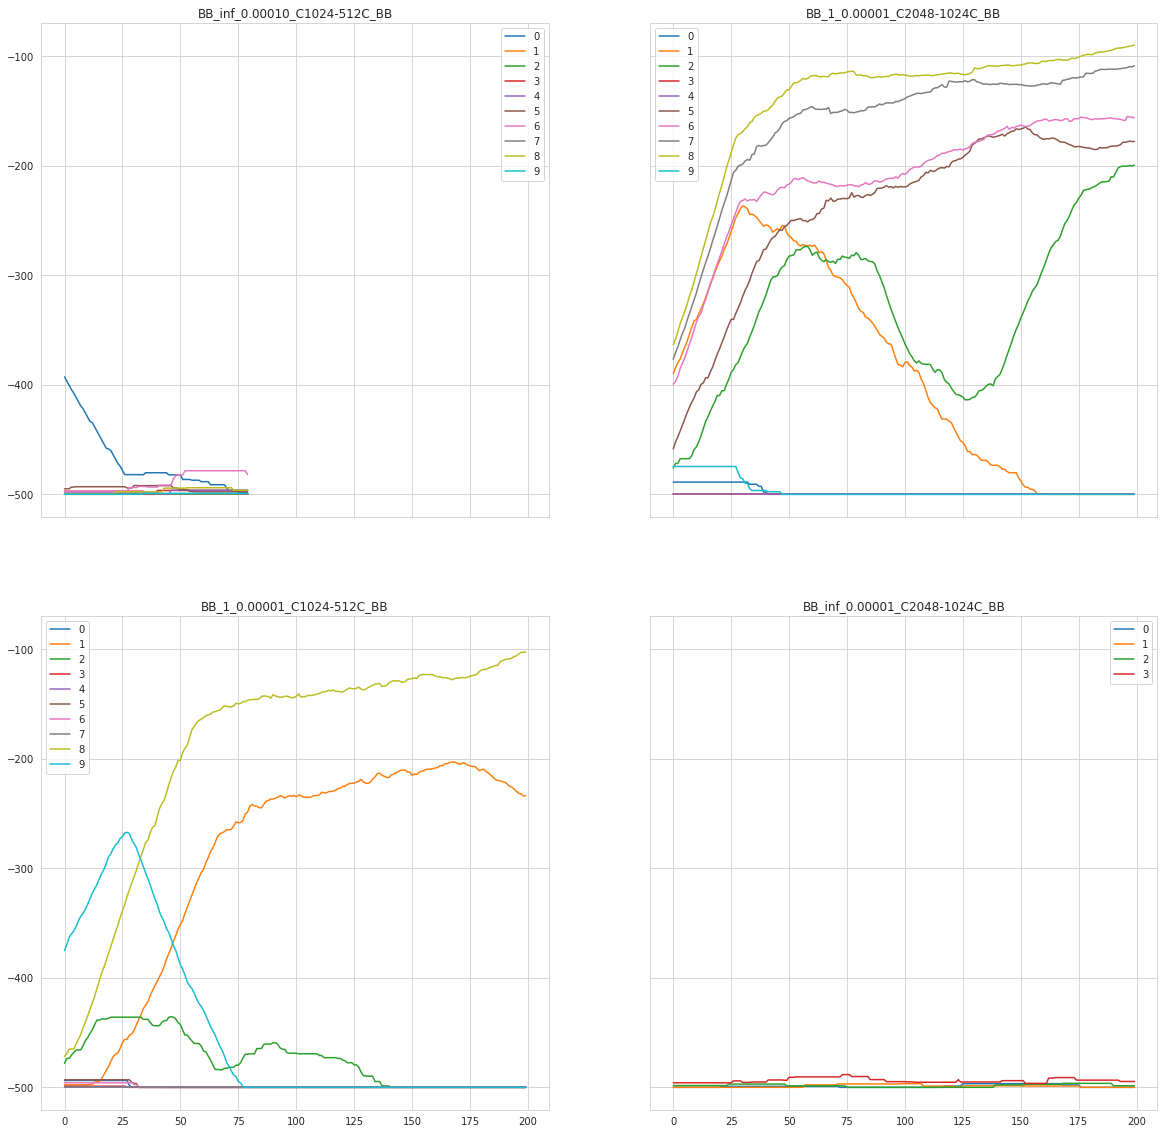

In [ ]:
env = 'Acrobot-v1'
non_zero = {k:v for k, v in complete_map[env].items() if len(v) != 0 }
n_plt = len(non_zero)

f, axs = plt.subplots(int(np.ceil(n_plt / 2)), 2, figsize=(10 * 2, n_plt * 5), sharex=True, sharey=True)
axs = axs.ravel()

for ax, (name, conf) in zip(axs, non_zero.items()):
    tss, rss, sss = load_paths(
        map(lambda x: x[1], conf)
        )
    for i, rs in enumerate(rss):
        ax.plot(mavg(rs, 51), label=f"{i}")
    ax.legend()
    ax.set_title(name)

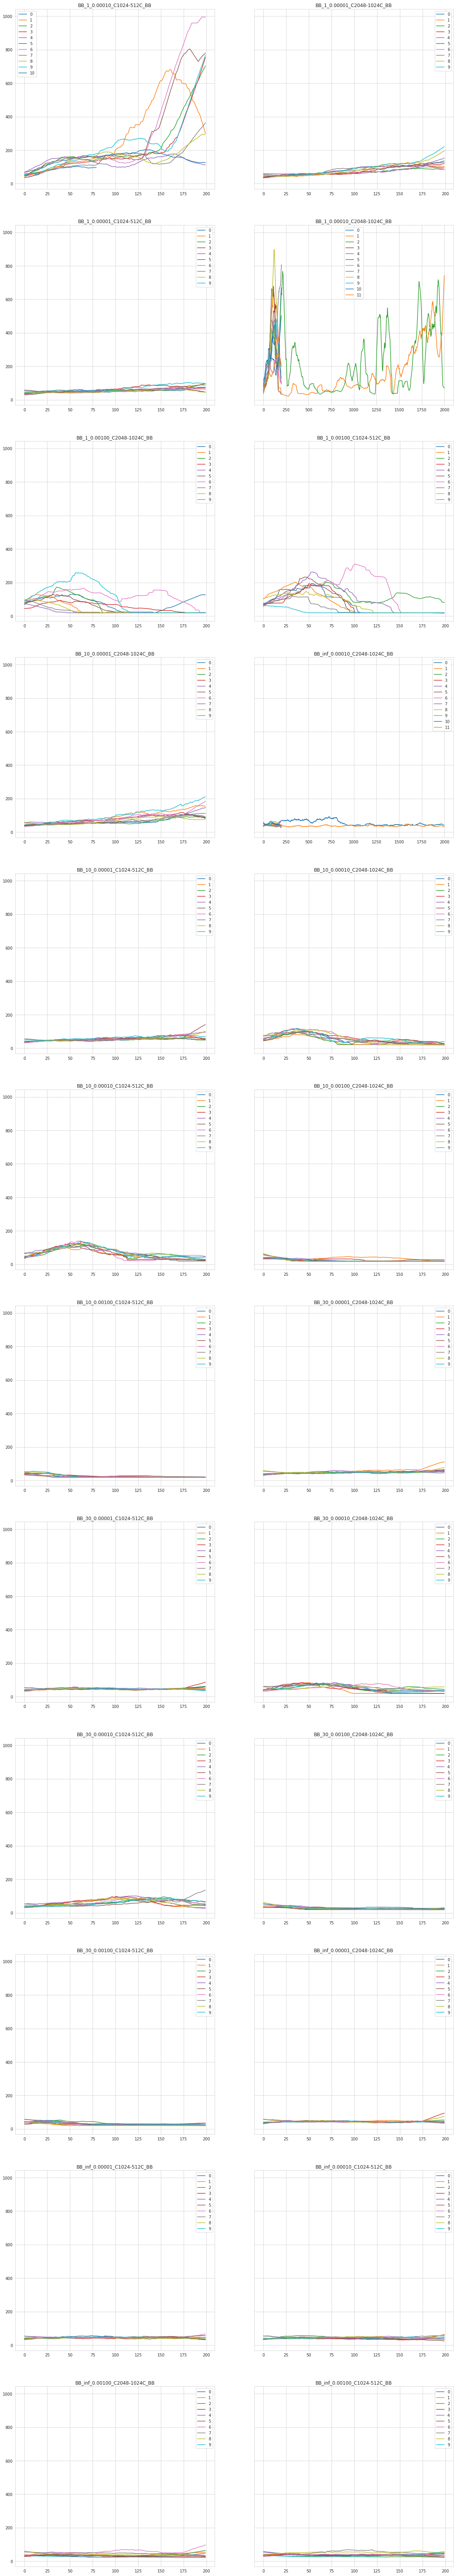

In [ ]:
env = 'CartPole-v1'
non_zero = {k:v for k, v in complete_map[env].items() if len(v) != 0 }
n_plt = len(non_zero)

f, axs = plt.subplots(int(np.ceil(n_plt / 2)), 2, figsize=(10 * 2, n_plt * 5), sharex=False, sharey=True)
axs = axs.ravel()

for ax, (name, conf) in zip(axs, non_zero.items()):
    tss, rss, sss = load_paths(map(lambda x: x[1], conf))
    for i, rs in enumerate(rss):
        ax.plot(mavg(rs, 51), label=f"{i}")
    ax.legend()
    ax.set_title(name)